In [ ]:
!pip install cma
!pip install torch
!pip install botorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.7/269.7 kB 3.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.spatial import KDTree
import itertools as it
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import torch
import math
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms import Standardize
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition import UpperConfidenceBound
import cma

In [ ]:
# Mount Drive manually using folder icon menu in colab notebook and then G Drive icon
# Get initial Values
inputs = np.load('/content/drive/My Drive/Imperial ML Course/Capstone Competition/function_8/initial_inputs.npy')
outputs = np.load('/content/drive/My Drive/Imperial ML Course/Capstone Competition/function_8/initial_outputs.npy')

In [ ]:
print(outputs)

[7.3987211  7.00522736 8.45948162 8.28400781 8.60611679 8.54174792
 7.32743458 7.29987205 7.95787474 5.59219339 7.85454099 6.79198578
 8.97655402 7.3790829  9.598482   8.15998319 7.13162397 6.76796253
 7.43374407 9.01307515 7.31089382 5.84106731 9.14163949 8.81755844
 6.45194313 8.83074505 9.34427428 6.88784639 8.04221254 7.69236805
 7.92375877 8.42175924 8.2780624  7.11345716 6.40258841 8.47293632
 7.97768459 7.46087219 7.43659353 9.18300525]


In [ ]:
#Add new Inputs and Outputs
new_inputs = np.array([[0.793186 ,0.690368, 0.62251,  0.773017, 0.254824, 0.624496, 0.115454, 0.048958],[0.630569 ,0.677336 ,0.191062 ,0.668676, 0.594854 ,0.154927 ,0.56569 , 0.020978], [0.76641 , 0.681154 ,0.269134 ,0.274721, 0.609851 ,0.953353 ,0.054115, 0.512674],[0.280766, 0.665901, 0.620377, 0.598931 ,0.618702, 0.891888 ,0.460581 ,0.935573],[0.548527, 0.476117, 0.588981, 0.581359, 0.483455, 0.504453, 0.731387, 0.528496],[0.584609, 0.766099, 0.572932, 0.449195, 0.583601, 0.593426, 0.702875, 0.555422]])
new_outputs = np.array([7.42237181, 8.437596503, 8.489106001187901, 8.42846909,8.0578577334279,7.9345384064051, ])

In [ ]:
inputs = np.append(inputs, new_inputs, axis = 0)
outputs = np.append(outputs, new_outputs)
print(outputs)

[7.3987211  7.00522736 8.45948162 8.28400781 8.60611679 8.54174792
 7.32743458 7.29987205 7.95787474 5.59219339 7.85454099 6.79198578
 8.97655402 7.3790829  9.598482   8.15998319 7.13162397 6.76796253
 7.43374407 9.01307515 7.31089382 5.84106731 9.14163949 8.81755844
 6.45194313 8.83074505 9.34427428 6.88784639 8.04221254 7.69236805
 7.92375877 8.42175924 8.2780624  7.11345716 6.40258841 8.47293632
 7.97768459 7.46087219 7.43659353 9.18300525 7.42237181 8.4375965
 8.489106   8.42846909 8.05785773 7.93453841]


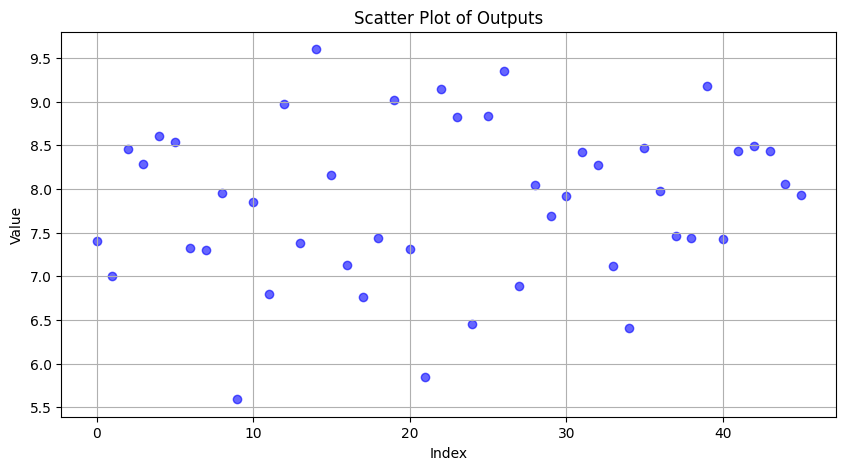

In [ ]:
#Visualise New Outputs
# Create indices for your outputs array
indices = np.arange(len(outputs))

plt.figure(figsize=(10, 5))  # Set the figure size
plt.scatter(indices, outputs, color='blue', alpha=0.6)  # Create a scatter plot
plt.title('Scatter Plot of Outputs')  # Set the title of the plot
plt.xlabel('Index')  # Set the x-axis label
plt.ylabel('Value')  # Set the y-axis label
plt.grid(True)  # Enable grid to make the plot easier to read
plt.show()  # Display the plot

In [ ]:
# Example data (replace with your actual inputs and outputs)
N = 8  # Number of dimensions

# Standardize the initial training data to zero mean and unit variance
def standardize(X):
    mean = X.mean(0)
    std = X.std(0)
    return (X - mean) / std, mean, std

def unstandardize(X, mean, std):
    return X * std + mean

# Standardize inputs and verifyX_standardized, mean_X, std_X = standardize(inputs)
print("Mean after standardization (should be close to 0):", X_standardized.mean(0))
print("Std after standardization (should be close to 1):", X_standardized.std(0))


# Convert to torch tensors
train_X = torch.tensor(X_standardized, dtype=torch.double)
train_Y = torch.tensor(outputs, dtype=torch.double).unsqueeze(-1)


# Define the model
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

# Define the acquisition function
acq_func = UpperConfidenceBound(model, beta=0.05)

# Define the objective for CMA-ES
def objective(x):
    x = torch.tensor(x, dtype=torch.double).unsqueeze(0)
    x_standardized = (x - mean_X) / std_X  # Standardize the input
    with torch.no_grad():
        acq_value = acq_func(x_standardized)
    return -acq_value.item()  # Negate because CMA-ES minimizes

# Initialize CMA-ES
es = cma.CMAEvolutionStrategy(train_X.mean(0).numpy(), 0.2, {'popsize': 20})

# Optimization loop
max_iter = 50  # Limit the number of iterations to avoid long runs
for _ in range(max_iter):
    solutions = es.ask()
    values = [objective(x) for x in solutions]
    es.tell(solutions, values)

# Best solution
best_solution = es.result.xbest
best_solution = torch.tensor(best_solution, dtype=torch.double).unsqueeze(0)
best_solution = unstandardize(best_solution, mean_X, std_X)

# Print best solution with 6 decimal places
best_solution_rounded = best_solution.numpy().round(6)

print(f"Best solution: {best_solution_rounded}")


Mean after standardization (should be close to 0): [ 6.30534272e-16  2.89623398e-17 -2.58850912e-16  2.75293073e-17
 -2.44973124e-16 -1.64119925e-16 -5.28562701e-16 -3.74096889e-17]
Std after standardization (should be close to 1): [1. 1. 1. 1. 1. 1. 1. 1.]


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([7.8561], dtype=torch.float64), std = tensor([0.9096], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 8 (seed=217674, Tue Jun 11 20:03:45 2024)
Best solution: [[0.555615 0.500647 0.580021 0.592049 0.489088 0.525468 0.71452  0.518743]]


## Change Log
#### 16th May
33/35 - using distance calculator

#### 19th May
33/37 - using distance calculator

#### 11th June <br>
Realise I have probably got the wrong settings at the outset and decide to get a bit more exploratory for a couple of weeks.  <br>
<ul>Position 37/40<br>
Change Beta from 0.05 <br>
Keep Pop Size 20 <br>
Set Sigma to 0.2 , from default of probably around 0.1</ul>


## Things to think about:
1.  Round output to six decimal places - DONE
2.  Switch standardisation to prior to conversion Torch tensors - DONE
3.   Consider modifying this code doesn't feel like this should be a numpy calculation feels like it should be a tensor - THIS CODE IS CORRECT IT SHOULD BE NUMPY

```
# # Initialize CMA-ES
es = cma.CMAEvolutionStrategy(train_X_standardized.mean(0).numpy(), 0.1, {'popsize': 20})This is formatted as code
```


4.  In the code above look for ways to manage the exploitation and exploration



### Managing Exploitation vs Exploration

The hyperparameters you should adjust to manage the exploration vs. exploitation trade-off are:

1. **Beta in Upper Confidence Bound (UCB) Acquisition Function**:
   - **Beta (`beta`)**: This parameter directly controls the balance between exploration and exploitation. A higher beta value increases the emphasis on exploration, while a lower beta value increases the emphasis on exploitation.
   
     ```python
     acq_func = UpperConfidenceBound(model, beta=0.1)  # Adjust beta value here
     ```

2. **Population Size in CMA-ES**:
   - **Population Size (`popsize`)**: This parameter affects the diversity of solutions considered in each iteration. A larger population size promotes more exploration, while a smaller population size can lead to quicker convergence (exploitation).

     ```python
     es = cma.CMAEvolutionStrategy(train_X.mean(0).numpy(), 0.1, {'popsize': 20})  # Adjust population size here
     ```

3. **Initial Step Size in CMA-ES**:
   - **Sigma (`sigma`)**: This parameter defines the initial step size for the search. A larger sigma can encourage exploration by allowing larger jumps in the search space, whereas a smaller sigma promotes more local search (exploitation).

     ```python
     es = cma.CMAEvolutionStrategy(train_X.mean(0).numpy(), 0.1, {'popsize': 20})  # Adjust sigma value here
     ```

By tuning these hyperparameters, you can control the degree to which your optimization process favors exploration of new areas versus exploitation of known good areas.

For example, increasing `beta` and `sigma`, and using a larger `popsize` will encourage more exploration, while decreasing these values will encourage exploitation. It is often useful to start with higher exploration values and gradually decrease them to focus on exploitation as the optimization progresses.

When tuning the hyperparameters for balancing exploration and exploitation in Gaussian optimization, the ranges you should consider for `beta`, `popsize`, and `sigma` are as follows:

### Beta (`beta`) for UCB Acquisition Function:
- **Range**: Typically between **0.1** and **10**.
- **Usage**:
  - Lower values (e.g., **0.1 to 1**) focus more on exploitation, i.e., they favor points with high predicted mean values.
  - Higher values (e.g., **1 to 10**) favor exploration by giving more weight to the uncertainty (variance) in the predictions.

### Population Size (`popsize`) for CMA-ES:
- **Range**: Generally between **5** and **50**, but can be larger depending on the problem complexity and dimensionality.
- **Usage**:
  - Smaller values (e.g., **5 to 10**) tend to focus more on exploitation, leading to faster convergence but potentially missing good solutions.
  - Larger values (e.g., **20 to 50**) encourage more exploration by maintaining diversity in the candidate solutions.

### Initial Step Size (`sigma`) for CMA-ES:
- **Range**: Typically between **0.01** and **1**.
- **Usage**:
  - Smaller values (e.g., **0.01 to 0.1**) focus on fine-tuning and local search, favoring exploitation.
  - Larger values (e.g., **0.1 to 1**) allow for broader search and exploration of the search space.

### Recommended Starting Points:
- **Beta (`beta`)**: Start with a moderate value, such as **1**. Adjust based on observed performance.
  ```python
  acq_func = UpperConfidenceBound(model, beta=1.0)
  ```
- **Population Size (`popsize`)**: Start with **20**. Increase if more exploration is needed.
  ```python
  es = cma.CMAEvolutionStrategy(train_X.mean(0).numpy(), 0.1, {'popsize': 20})
  ```
- **Initial Step Size (`sigma`)**: Start with **0.1**. Adjust based on convergence speed and solution diversity.
  ```python
  es = cma.CMAEvolutionStrategy(train_X.mean(0).numpy(), 0.1<-THIS IS SIGMA, {'popsize': 20})
  ```

### Fine-Tuning Strategy:
1. **Start with a balanced configuration**: Choose moderate values for all parameters.
2. **Monitor performance**: Observe how well the optimization process is converging and the diversity of solutions.
3. **Adjust iteratively**:
   - If the optimization is converging too quickly to local optima, increase `beta`, `popsize`, or `sigma`.
   - If the optimization is not converging or is too slow, decrease these parameters to focus more on exploitation.

By experimenting with these ranges and observing the results, you can fine-tune the hyperparameters to achieve the desired balance between exploration and exploitation for your specific optimization problem.

### 15th June m_ START FROM HERE
Turns out what I was doing with TURBO was wrong.  I was failing to set the local area to be optimised or tracking state of the function.  Now trying again following the tutorial.
### Defines a data class to store the the state

In [ ]:
from dataclasses import dataclass
import numpy as np
import torch
import math
from botorch.generation import MaxPosteriorSampling
from torch.quasirandom import SobolEngine
import botorch
import gpytorch
import matplotlib.pyplot as plt


In [ ]:
# we define a dataclass for our state this is used to store the state of the area
@dataclass
class TurboState:
    dim: int # dimension of the problem, aka input dimension
    batch_size: int = 1 # we could do batch optimization, but the capstone only does one query at a time
    length: float = 0.4 # the length of the current trust region
    length_min: float = 0.25 ** 7 # minimum length for the trust region
    length_max: float = 0.5 # maximum length for the trust region
    failure_counter: int = 0 # initialize counter of the number of failures to improve on the best observation
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0 # initialize counter of the number of success to improve on the best observation
    success_tolerance: int = 10  # Note: The original paper uses 3, this is the number of successes in a row needed to expand the region
    best_value: float = -float("inf") # best value so far, initialized to be the infimum
    restart_triggered: bool = False

    # This method is automatically called after the dataclass is initialized. It sets the failure_tolerance attribute based on the dimension and batch size:
    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size]) # number of failures needed in a row to shrink the trust region
        )

# this updates the state depending on Y_next
def update_state(state, Y_next):

    # count if a success, otherwise a failure
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1
    # check if we need to expand or shrink the trust region
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0
    # set the best value if we got a new observation
    state.best_value = max(state.best_value, max(Y_next))
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

This defines a function to set the initial state from your previous run

In [ ]:
def create_initial_state(dim, batch_size=1, length=0.4, length_min=0.25**7, length_max=0.5, failure_counter = 0, success_counter=0, success_tolerance=10, best_value = 1, restart_triggered = False):
    return TurboState(
        dim=dim,
        batch_size=batch_size,
        length=length,
        length_min=length_min,
        length_max=length_max,
        failure_counter=0,
        success_counter=0,
        success_tolerance=success_tolerance,
        best_value=-float("inf"),
        restart_triggered=False
    )



### This updates and prints the state
It is important to record these variables after choosing a new query, and re-input, and update to the correct state when we receive new observations. An example of this will be given later. We can then define the TuRBO loop:

In [ ]:
#Step 1 Re-initialise the State UPDATE PARAMETERS HERE
state = TurboState(
    dim=8,
    batch_size=1,
    length=0.3,
    length_max=0.5,
    success_tolerance=3,
    failure_counter=5,
    success_counter=0,
    best_value= 9.755085388342168
)

#Step 2 Update the State with the new function PLACE NEw VALUE HERE
y_next = [9.6783991984489]
new_state = update_state(state, y_next)

print(state)
#Step 3 NOW append the new values!!!


TurboState(dim=8, batch_size=1, length=0.3, length_min=6.103515625e-05, length_max=0.5, failure_counter=6, failure_tolerance=8, success_counter=0, success_tolerance=3, best_value=9.755085388342168, restart_triggered=False)


This code defines a function generate_batch that generates a new batch of candidate points for evaluation in a trust region optimization algorithm using Thompson sampling (TS) as the acquisition function.
<ul>Adjusts the trust region based on the current best point and the GP model's lengthscales.<br>
Generates candidate points within this trust region using a Sobol sequence and a perturbation mask.<br>
Evaluates the GP model at these candidate points.<br>
Uses Thompson sampling to select the best candidate point as the next point to evaluate.<br>
This function helps guide the optimization process by suggesting new points to evaluate, balancing exploration and exploitation within the trust region.<br>
The function uses a GPyTorch model as an input. A tutorial on how GPyTorch models can be used is found here: https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html


In [ ]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size = 1, # fix batch size to 1
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the trust region to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)
    # we focus only on thompson sampling as an acquisition function
    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(10.0 / dim, 1.0)
        mask = (
            torch.rand(n_candidates, dim)
            <= prob_perturb
        )
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),))] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        # set model to evaluation mode
        model.eval()
        posterior_distribution = model(X_cand)
        with torch.no_grad():  # We don't need gradients when using TS
            posterior_sample = posterior_distribution.sample()
            X_next_idx = torch.argmax(posterior_sample)
            X_next = X_cand[X_next_idx]

    return X_next

The below ExactGPModel class defines a Gaussian Process model with the following characteristics:

* It uses a constant mean function, which assumes a constant mean across the input space.
* It employs an RBF kernel with ARD, allowing different length scales for each input dimension.
* It wraps the RBF kernel with a scale kernel to scale the kernel output.
* The number of training iterations for hyper-parameter optimization is set to 200.<br>
* The forward method specifies how to compute the GP's predictive distribution given new input points.



In [ ]:
# we use the model given in the tutorial, we also add the hyper-parameter training as a method
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # set a constant mean
        self.mean_module = gpytorch.means.ConstantMean()
        # use a simple RBF kernel with constant scaling
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))
        # set number of hyper-parameter training iterations
        self.training_iter = 200

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# Mount Drive manually using folder icon menu in colab notebook and then G Drive icon
# Get initial Values
inputs1 = np.load('/content/drive/My Drive/Imperial ML Course/Capstone Competition/function_8/initial_inputs.npy')
outputs1 = np.load('/content/drive/My Drive/Imperial ML Course/Capstone Competition/function_8/initial_outputs.npy')
inputs2 = np.load('/content/drive/My Drive/Imperial ML Course/Capstone Competition/function_8/initial_inputs2.npy')
outputs2 = np.load('/content/drive/My Drive/Imperial ML Course/Capstone Competition/function_8/initial_outputs2.npy')

# Concatenate inputs and outputs
inputs = np.concatenate((inputs1, inputs2), axis=0)
outputs = np.concatenate((outputs1, outputs2), axis=0)


#Import check
print(len(inputs1),len(inputs2),len(inputs))
print(len(outputs1),len(outputs2),len(outputs))


40 40 80
40 40 80


In [ ]:
#Add new Inputs and Outputs
new_inputs = np.array([[0.793186 ,0.690368, 0.62251,  0.773017, 0.254824, 0.624496, 0.115454, 0.048958],[0.630569 ,0.677336 ,0.191062 ,0.668676, 0.594854 ,0.154927 ,0.56569 , 0.020978], [0.76641 , 0.681154 ,0.269134 ,0.274721, 0.609851 ,0.953353 ,0.054115, 0.512674],[0.280766, 0.665901, 0.620377, 0.598931 ,0.618702, 0.891888 ,0.460581 ,0.935573],[0.548527, 0.476117, 0.588981, 0.581359, 0.483455, 0.504453, 0.731387, 0.528496],[0.584609, 0.766099, 0.572932, 0.449195, 0.583601, 0.593426, 0.702875, 0.555422],[0.225493, 0.258548, 0.203239, 0.214666, 0.450381, 0.626126, 0.651202, 0.744136],[0.232844, 0.255303, 0.136991, 0.221564, 0.59723,  0.632976, 0.60138,  0.814389],[0.119858, 0.215834, 0.164473, 0.132299, 0.401466, 0.801033 ,0.412237 ,0.74602 ],[0.171321 ,0.207121, 0.321749, 0.161845, 0.330898, 0.481808, 0.406726, 0.703364],[0.152954, 0.156845, 0.268139, 0.147864, 0.261787, 0.505364, 0.420783, 0.697183],[0.179106, 0.243388 ,0.287803 ,0.157738 ,0.379374 ,0.504868, 0.443346, 0.747578], [0.171192, 0.231361, 0.228502, 0.16474,  0.298222, 0.511386, 0.47148,  0.744789]])
new_outputs = np.array([7.42237181, 8.437596503, 8.489106001187901, 8.42846909,8.0578577334279,7.9345384064051, 9.4501783019649,9.583299667,9.728741901483,9.6792214983814,9.6937930723766,9.6948986345106,9.6783991984489])

inputs = np.append(inputs, new_inputs, axis = 0)
outputs = np.append(outputs, new_outputs)
print(outputs)
print(np.max(outputs))

[7.3987211  7.00522736 8.45948162 8.28400781 8.60611679 8.54174792
 7.32743458 7.29987205 7.95787474 5.59219339 7.85454099 6.79198578
 8.97655402 7.3790829  9.598482   8.15998319 7.13162397 6.76796253
 7.43374407 9.01307515 7.31089382 5.84106731 9.14163949 8.81755844
 6.45194313 8.83074505 9.34427428 6.88784639 8.04221254 7.69236805
 7.92375877 8.42175924 8.2780624  7.11345716 6.40258841 8.47293632
 7.97768459 7.46087219 7.43659353 9.18300525 7.38153659 6.21406582
 8.34373778 8.20235493 7.0175736  8.15436185 8.59988062 7.41496438
 6.35307753 7.04891614 8.83964993 9.75508539 9.069804   8.33091139
 9.08235861 9.06259425 7.88211016 6.8055637  9.22168616 8.57638926
 6.45101025 8.95855365 8.30868114 9.23898119 7.41316123 8.28986748
 8.14792352 6.56627417 8.64815107 8.10407818 8.67513919 8.73943795
 7.55172428 8.25528511 6.61336583 6.03732966 6.86721166 7.03597564
 7.47931514 5.15380413 7.42237181 8.4375965  8.489106   8.42846909
 8.05785773 7.93453841 9.4501783  9.58329967 9.7287419  9.6792

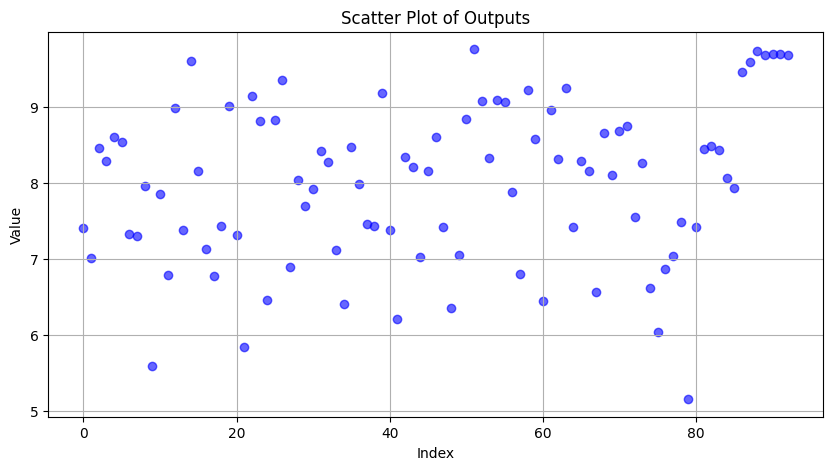

In [ ]:
#Visualise New Outputs
# Create indices for your outputs array
indices = np.arange(len(outputs))

plt.figure(figsize=(10, 5))  # Set the figure size
plt.scatter(indices, outputs, color='blue', alpha=0.6)  # Create a scatter plot
plt.title('Scatter Plot of Outputs')  # Set the title of the plot
plt.xlabel('Index')  # Set the x-axis label
plt.ylabel('Value')  # Set the y-axis label
plt.grid(True)  # Enable grid to make the plot easier to read
plt.show()  # Display the plot

In [ ]:


# Convert to torch tensors
train_X = torch.from_numpy(inputs).to(torch.float32)
train_Y = torch.from_numpy(outputs).to(torch.float32)


This function sets up and trains a GP model with a Gaussian likelihood using the gpytorch library. The key steps include:

* Initializing the likelihood and model.
* Setting the model and likelihood to training mode.
* Setting up the Adam optimizer.
* Defining the marginal log likelihood as the loss function.
* Running a training loop for a specified number of iterations, where in each iteration:
* Gradients are zeroed.
* The model makes predictions on the training data.
* The negative log likelihood loss is computed and backpropagated.
* Model parameters are updated using the Adam optimizer.

In [ ]:
def next_query_via_TurBO(train_x, train_y, turbo_state, verbose = False):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    for i in range(model.training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_X)
        # Calc loss and backprop gradients
        print(output)
        print(train_Y.dtype)
        break
        loss = -mll(output, train_Y)
        loss.backward()
        if i % 10 == 9:
            print(f'Iter %d/%d - Loss: %.6f   lengthscale: {model.covar_module.base_kernel.lengthscale.detach()}   noise: %.6f' % (
                i + 1, model.training_iter, loss.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

    return generate_batch(turbo_state, model = model, X = train_x, Y = train_y)

In [ ]:
print(np.max(outputs))

9.755085388342168


In [ ]:
#Step 4 Run the next Query Function
next_query = next_query_via_TurBO(train_x=train_X, train_y=train_Y, turbo_state=state)
formatted_query = [f'{item:.6f}' for item in next_query]
formatted_output = f'{formatted_query[0]}-{formatted_query[1]}-{formatted_query[2]}-{formatted_query[3]}-{formatted_query[4]}-{formatted_query[5]}-{formatted_query[6]}-{formatted_query[7]}'
print(f'Next chosen query: {formatted_output}')
print(state)
# Step 5 Record the state so you can do it again

MultivariateNormal(loc: torch.Size([93]))
torch.float32


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Next chosen query: 0.161232-0.153123-0.131289-0.152186-0.414921-0.465680-0.451768-0.687693
TurboState(dim=8, batch_size=1, length=0.3, length_min=6.103515625e-05, length_max=0.5, failure_counter=6, failure_tolerance=8, success_counter=0, success_tolerance=3, best_value=9.755085388342168, restart_triggered=False)


Entry 15th Jun: <br>MultivariateNormal(loc: torch.Size([46]))
torch.float32
Next chosen query: 0.225493-0.258548-0.203239-0.214666-0.450381-0.626126-0.651202-0.744136
TurboState(dim=8, batch_size=1, length=0.4, length_min=6.103515625e-05, length_max=0.5, failure_counter=0, failure_tolerance=8, success_counter=0, success_tolerance=10, best_value=-inf, restart_triggered=False)

Entry 20th June - this is a restart <br>
Next chosen query: 0.232844-0.255303-0.136991-0.221564-0.597230-0.632976-0.601380-0.814389
TurboState(dim=8, batch_size=1, length=0.4, length_min=6.103515625e-05, length_max=0.5, failure_counter=0, failure_tolerance=8, success_counter=0, success_tolerance=10, best_value=-inf, restart_triggered=False)


Entry 23rd June<br>
Next chosen query: 0.119858-0.215834-0.164473-0.132299-0.401466-0.801033-0.412237-0.746020
TurboState(dim=8, batch_size=1, length=0.3, length_min=6.103515625e-05, length_max=0.5, failure_counter=1, failure_tolerance=8, success_counter=0, success_tolerance=3, best_value=9.598482002566342, restart_triggered=False)


Steps to run the TURBO loop:
1. Re initialise the state based on the last run using create_inital State function
2.  Update the state with the update state function using the new result
3.  Append the last round of input values and results into the arrays
4.  Run the next query function to get the next query
5. Record the state that comes out so you can do it again

### 20th June
* realised I had got it wrong when I ran it for the first time by failed to initialise the state with a best value.
* Learning need to make sure understand the process completely

Entry 7th July <br>
Next chosen query: 0.171321-0.207121-0.321749-0.161845-0.330898-0.481808-0.406726-0.703364
TurboState(dim=8, batch_size=1, length=0.3, length_min=6.103515625e-05, length_max=0.5, failure_counter=2, failure_tolerance=8, success_counter=0, success_tolerance=3, best_value=9.755085388342168, restart_triggered=False)


Entry 11th July<br>
Next chosen query: 0.152954-0.156845-0.268139-0.147864-0.261787-0.505364-0.420783-0.697183
TurboState(dim=8, batch_size=1, length=0.3, length_min=6.103515625e-05, length_max=0.5, failure_counter=3, failure_tolerance=8, success_counter=0, success_tolerance=3, best_value=9.755085388342168, restart_triggered=False)


Entry 13th July<br>
Next chosen query: 0.179106-0.243388-0.287803-0.157738-0.379374-0.504868-0.443346-0.747578
TurboState(dim=8, batch_size=1, length=0.3, length_min=6.103515625e-05, length_max=0.5, failure_counter=4, failure_tolerance=8, success_counter=0, success_tolerance=3, best_value=9.755085388342168, restart_triggered=False)


Entry 17th July<br>
* Reduced prob_perturb = min(10.0 / dim, 1.0)  # Lower probability for more exploitation.  This is in the generate_batch function<br>
<br>Next chosen query: 0.171192-0.231361-0.228502-0.164740-0.298222-0.511386-0.471480-0.744789
TurboState(dim=8, batch_size=1, length=0.3, length_min=6.103515625e-05, length_max=0.5, failure_counter=5, failure_tolerance=8, success_counter=0, success_tolerance=3, best_value=9.755085388342168, restart_triggered=False)



Entry 21st July<br>
Next chosen query: 0.161232-0.153123-0.131289-0.152186-0.414921-0.465680-0.451768-0.687693
TurboState(dim=8, batch_size=1, length=0.3, length_min=6.103515625e-05, length_max=0.5, failure_counter=6, failure_tolerance=8, success_counter=0, success_tolerance=3, best_value=9.755085388342168, restart_triggered=False)
